In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import html 
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
## Depracated:
# from sklearn.metrics import plot_confusion_matrix
## New version:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.dummy import DummyClassifier
from blueprints.preparation import clean

In [2]:
df = pd.read_csv("./data/eclipse_jdt.csv")
print(df.columns)
df[['Issue_id', 'Priority', 'Component', 'Title', 'Description']].sample(2)

Index(['Issue_id', 'Priority', 'Component', 'Duplicated_issue', 'Title',
       'Description', 'Status', 'Resolution', 'Version', 'Created_time',
       'Resolved_time'],
      dtype='object')


,Issue_id,Priority,Component,Title,Description
39169,258122,P3,Debug,EmptyStackException evaluating switch statemen...,In the Java5Evaluations test class; set a brea...
43419,373571,P3,Core,[null][regression] Incorrect application of nu...,With the following two classes I get ; ; The r...


In [3]:
df.sample(1).T

,8758
Issue_id,24552
Priority,P3
Component,UI
Duplicated_issue,NaN
Title,Restoring hierarchy views
Description,Build 20021001; ; When restarting Eclipse with...
Status,RESOLVED
Resolution,FIXED
Version,2.0
Created_time,2002-10-09 05:43:00 -0400


<Axes: xlabel='Priority'>

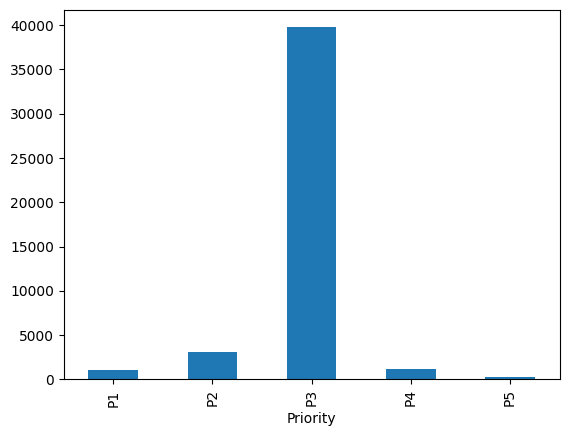

In [6]:
df['Priority'].value_counts().sort_index().plot(kind='bar')

In [7]:
df['Component'].value_counts()

Component
UI       17479
Core     13669
Debug     7542
Text      5901
APT        406
Doc        299
Name: count, dtype: int64

In [9]:
df = df[['Title','Description','Priority']]
df = df.dropna()
df['text'] = df['Title'] + ' ' + df['Description']
df = df.drop(columns=['Title','Description'])
df.columns

Index(['Priority', 'text'], dtype='object')

In [10]:
from blueprints.preparation import clean
df['text'] = df['text'].apply(clean)
df = df[df['text'].str.len() > 50]
df.sample(2, random_state=0)

,Priority,text
42439,P3,Regression in TypeHierarchyPerfTest#testOpenOb...
30486,P3,introduce indirection: misleading warning abou...


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print('Size of Training Data ', X_train.shape[0])
print('Size of Test Data ', X_test.shape[0])

Size of Training Data  36040
Size of Test Data  9011


In [12]:
tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words="english")
X_train_tf = tfidf.fit_transform(X_train)

In [17]:
model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_tf, Y_train)

h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05)

In [18]:
X_test_tf = tfidf.transform(X_test)

In [19]:
Y_pred = model1.predict(X_test_tf)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred))

Accuracy Score -  0.8761513705471091


In [20]:
clf = DummyClassifier(strategy='most_frequent', random_state=42)
clf.fit(X_train, Y_train)
Y_pred_baseline = clf.predict(X_test)
print ('Accuracy Score - ', accuracy_score(Y_test, Y_pred_baseline))

Accuracy Score -  0.8769281988680502


In [21]:
Y_pred = model1.predict(X_test_tf)
confusion_matrix(Y_test, Y_pred)

array([[  19,    1,  199,    4,    0],
       [   6,   18,  576,    8,    0],
       [   8,   48, 7827,   19,    0],
       [   0,    5,  192,   31,    0],
       [   0,    0,   50,    0,    0]], dtype=int64)

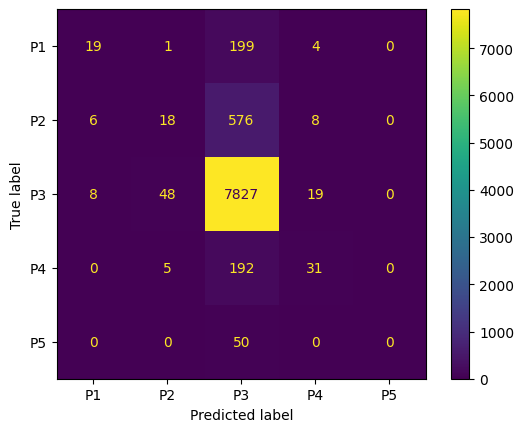

In [22]:
cm = confusion_matrix(Y_test, Y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = model1.classes_)
disp.plot()
plt.show()

In [23]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

          P1       0.58      0.09      0.15       223
          P2       0.25      0.03      0.05       608
          P3       0.89      0.99      0.93      7902
          P4       0.50      0.14      0.21       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.88      9011
   macro avg       0.44      0.25      0.27      9011
weighted avg       0.82      0.88      0.83      9011



h:\study\genesis\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
h:\study\genesis\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
h:\study\genesis\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# Filter bug reports with priority P3 and sample 4000 rows from it
df_sampleP3 = df[df['Priority'] == 'P3'].sample(n=4000, random_state=123)

# Create a separate dataframe containing all other bug reports
df_sampleRest = df[df['Priority'] != 'P3']

# Concatenate the two dataframes to create the new balanced bug reports dataset
df_balanced = pd.concat([df_sampleRest, df_sampleP3])

# Check the status of the class imbalance
df_balanced['Priority'].value_counts()

Priority
P3    4000
P2    3038
P4    1138
P1    1117
P5     252
Name: count, dtype: int64

In [28]:
df = df_balanced[['text','Priority']]
df = df.dropna()

df['text'] = df['text'].apply(clean)

X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['Priority'],
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=df['Priority'])

print(f'Size of Training data: {X_train.shape[0]}')
print(f'Size of Test data: {X_test.shape[0]}')

tfidf = TfidfVectorizer(min_df=10, ngram_range=(1,2), stop_words="english")
X_train_df = tfidf.fit_transform(X_train)

model1 = LinearSVC(random_state=0, tol=1e-5)
model1.fit(X_train_df, y_train)

X_test_tf = tfidf.transform(X_test)
y_pred = model1.predict(X_test_tf)
print(f'Accuracy Score - {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Size of Training data: 7636
Size of Test data: 1909


h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy Score - 0.5028810895756941
              precision    recall  f1-score   support

          P1       0.44      0.29      0.35       223
          P2       0.45      0.48      0.46       608
          P3       0.56      0.66      0.60       800
          P4       0.47      0.34      0.39       228
          P5       0.00      0.00      0.00        50

    accuracy                           0.50      1909
   macro avg       0.38      0.35      0.36      1909
weighted avg       0.48      0.50      0.49      1909



In [29]:
clf = DummyClassifier(strategy='stratified')
clf.fit(X_train, y_train)
y_pred_baseline = clf.predict(X_test)
print(f'Accuracy Score - {accuracy_score(y_test, y_pred_baseline)}')

Accuracy Score - 0.322158198009429


In [31]:
frame = { 'text': X_test, 'actual': y_test, 'predicted': y_pred }
result = pd.DataFrame(frame)

result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] == result['predicted'])].sample(2, random_state=22)

,text,actual,predicted
8461,Variable view show old instance using build 20...,P1,P1
34854,model proxy created for Java debug target in v...,P2,P2


In [32]:
result[((result['actual'] == 'P1') | (result['actual'] == 'P2')) &
       (result['actual'] != result['predicted'])].sample(2, random_state=22)

,text,actual,predicted
6015,MultiTypeSelectionDialog ignores filter settin...,P2,P3
140,Missing toString() feature makes debugging pai...,P2,P4


### 교차 검증

In [33]:
tfidf = TfidfVectorizer(min_df = 10, ngram_range=(1,2), stop_words="english")
df_tf = tfidf.fit_transform(df['text']).toarray()

In [35]:
scores = cross_val_score(estimator=model1,
                         X=df_tf,
                         y=df['Priority'],
                         cv=5)
print(f'Validation scores from each iteration of the cross validation: {scores}')
print(f'Mean value across of validation scores: {scores.mean()}')
print(f'Standard deviation of validation scores: {scores.std()}')

h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: Futu

Validation scores from each iteration of the cross validation: [0.48192771 0.45311682 0.43949712 0.42221058 0.37297014]
Mean value across of validation scores: 0.43394447354635934
Standard deviation of validation scores: 0.036211476115013436


### 그리드 검색틀 통한 하이퍼파라미터 조정

In [41]:
training_pipeline = Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                                    ('model', LinearSVC(random_state=42, tol=1e-5))])

grid_params = [{
                'tfidf__min_df': [5, 10],
                'tfidf__ngram_range': [(1,3), (1,6)],
                'model__penalty': ['l2'],
                'model__loss': ['hinge'],
                'model__max_iter': [10000]}, 
               {
                'tfidf__min_df': [5,10],
                'tfidf__ngram_range': [(1,3), (1,6)],
                'model__C': [1, 10],
                'model__tol': [1e-2, 1e-3]}
              ]

In [43]:
gridSearchProcessor = GridSearchCV(estimator=training_pipeline,
                                   param_grid=grid_params,
                                   cv=5)
gridSearchProcessor.fit(df['text'], df['Priority'])

best_params = gridSearchProcessor.best_params_
print(f'Best alpha parameter identified by grid search: {best_params}')

best_result = gridSearchProcessor.best_score_
print(f'Best result identified by grid search: {best_result}')

h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
h:\study\genesis\venv\lib\site-packages\sklearn\svm\_classes.py:32: Futu

Best alpha parameter identified by grid search: {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search: 0.4597171293871137


In [44]:
gridsearch_results = pd.DataFrame(gridSearchProcessor.cv_results_)
gridsearch_results[['rank_test_score', 'mean_test_score',
                    'params']].sort_values(by=['rank_test_score'])[:5]

,rank_test_score,mean_test_score,params
2,1,0.459717,"{'model__loss': 'hinge', 'model__max_iter': 10..."
0,2,0.459193,"{'model__loss': 'hinge', 'model__max_iter': 10..."
1,3,0.458041,"{'model__loss': 'hinge', 'model__max_iter': 10..."
3,4,0.456888,"{'model__loss': 'hinge', 'model__max_iter': 10..."
4,5,0.439497,"{'model__C': 1, 'model__tol': 0.01, 'tfidf__mi..."


In [45]:
best_params = gridSearchProcessor.best_params_
print("Best alpha parameter identified by grid search ", best_params)

best_result = gridSearchProcessor.best_score_
print("Best result identified by grid search ", best_result)

best_model = gridSearchProcessor.best_estimator_

y_pred = best_model.predict(X_test)
print('Accuracy Score - ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Best alpha parameter identified by grid search  {'model__loss': 'hinge', 'model__max_iter': 10000, 'model__penalty': 'l2', 'tfidf__min_df': 10, 'tfidf__ngram_range': (1, 3)}
Best result identified by grid search  0.4597171293871137
Accuracy Score -  0.7700366684127815
              precision    recall  f1-score   support

          P1       0.83      0.61      0.70       223
          P2       0.77      0.75      0.76       608
          P3       0.75      0.89      0.81       800
          P4       0.83      0.65      0.73       228
          P5       1.00      0.30      0.46        50

    accuracy                           0.77      1909
   macro avg       0.83      0.64      0.69      1909
weighted avg       0.78      0.77      0.76      1909

